In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Problem definition
num_steps = 100  # Number of simulation steps
q_var = 0.01**2  # State noise variance
r_var = 0.02     # Measurement noise variance
np.random.seed(42)  # Reproducibility


In [10]:
def simulate_model(num_steps):
    """
    Simulate the true states and measurements over a given number of steps.
    """
    x_true = np.zeros(num_steps)  # True state array
    y_meas = np.zeros(num_steps)  # Measurement array
    
    # Initial state x_0 = 0
    x_true[0] = 0  
    
    for k in range(1, num_steps):
        q_k = np.random.normal(0, np.sqrt(q_var))  # State noise
        x_true[k] = x_true[k-1] - 0.01 * np.sin(x_true[k-1]) + q_k
        
        r_k = np.random.normal(0, np.sqrt(r_var))  # Measurement noise
        y_meas[k] = 0.5 * np.sin(2 * x_true[k]) + r_k
        
    return x_true, y_meas


In [11]:
def particle_filter(y_meas, num_particles=1000):
    """
    Particle filter implementation for state estimation.
    """
    num_steps = len(y_meas)  # Total time steps
    particles = np.zeros((num_steps, num_particles))  # Particle matrix
    weights = np.ones((num_steps, num_particles)) / num_particles  # Uniform weights
    estimates = np.zeros(num_steps)  # Estimated states
    
    # Initialize particles around the initial state (close to zero)
    particles[0] = np.random.normal(loc=0, scale=0.1, size=num_particles)
    
    for k in range(1, num_steps):
        # Prediction step
        particles[k] = particles[k-1] - 0.01 * np.sin(particles[k-1]) + np.random.normal(0, np.sqrt(q_var), num_particles)
        
        # Weight update based on measurement likelihood
        weights[k] = np.exp(-0.5 * ((y_meas[k] - 0.5 * np.sin(2 * particles[k]))**2) / r_var)
        weights[k] /= np.sum(weights[k])  # Normalize weights
        
        # Resampling step
        indices = np.random.choice(num_particles, num_particles, p=weights[k])
        particles[k] = particles[k][indices]
        weights[k] = np.ones(num_particles) / num_particles  # Reset weights after resampling
        
        # State estimation using the mean of particles
        estimates[k] = np.mean(particles[k])
    
    return estimates, particles


In [12]:
def calculate_rmse(x_true, estimates):
    """
    Compute the Root Mean Square Error (RMSE) between true and estimated states.
    """
    return np.sqrt(np.mean((x_true - estimates)**2))


Particle Filter RMSE: 0.0263


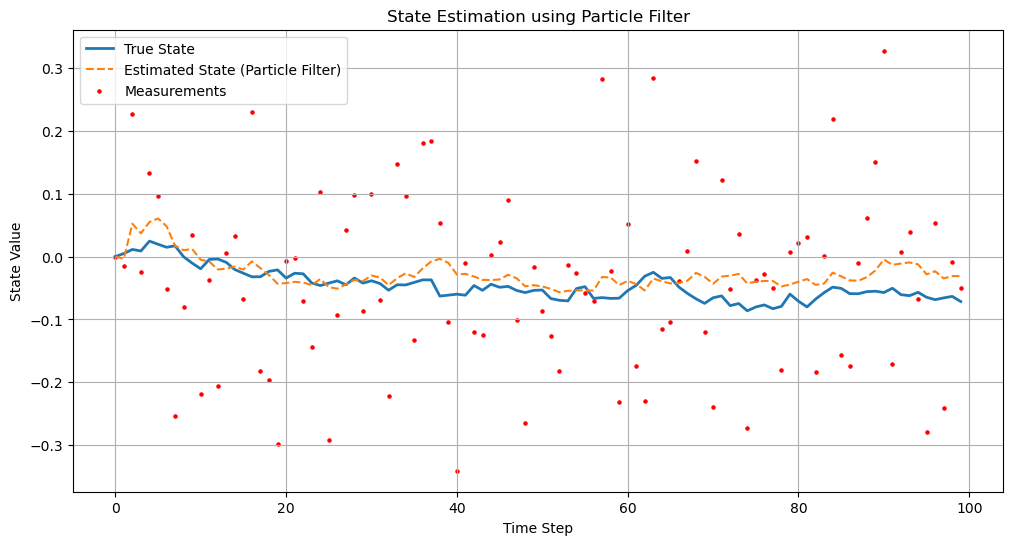

In [13]:
# Simulate true states and measurements
x_true, y_meas = simulate_model(num_steps)

# Apply particle filter
estimates, particles = particle_filter(y_meas)

# Compute RMSE
rmse = calculate_rmse(x_true, estimates)

# Display RMSE
print(f"Particle Filter RMSE: {rmse:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x_true, label='True State', linewidth=2)
plt.plot(estimates, label='Estimated State (Particle Filter)', linestyle='--')
plt.scatter(range(num_steps), y_meas, color='red', s=5, label='Measurements')
plt.title('State Estimation using Particle Filter')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.grid()
plt.show()
